In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from qiime2 import Artifact
from skbio.stats.ordination import OrdinationResults
from skbio.stats.distance import DistanceMatrix, permanova

%matplotlib inline

In [3]:
! qiime diversity core-metrics-phylogenetic \
--i-table Data/noMito_noChloro-filtered-table.qza \
--i-phylogeny Data/insertion-tree.qza \
--p-sampling-depth 10843 \
--m-metadata-file Data/IBS-metadata.txt \
--output-dir Data/core-metrics-results

Saved FeatureTable[Frequency] to: Data/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: Data/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: Data/core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Data/core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Data/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Data/core-metrics-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: Data/core-metrics-results/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: Data/core-metrics-results/jaccard_pcoa_results.qza
Sa

In [2]:
u_uni_pcoa = Artifact.load("Data/core-metrics-results/unweighted_unifrac_pcoa_results.qza").view(OrdinationResults)
metadata = pd.read_csv("Data/IBS-metadata.txt", sep="\t", index_col="Sampleid")

u_uni_plotdata = u_uni_pcoa.samples
u_uni_plotdata = u_uni_plotdata.reindex(metadata.index)
u_uni_plotdata["IBS"] = metadata["IBS"].apply(lambda x: "Healthy Control" if x=="N" else "IBS")
u_uni_plotdata["IBS Type"] = metadata["IBS Type"].apply(lambda x: "Healthy Control" if x=="control" else x)

In [12]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

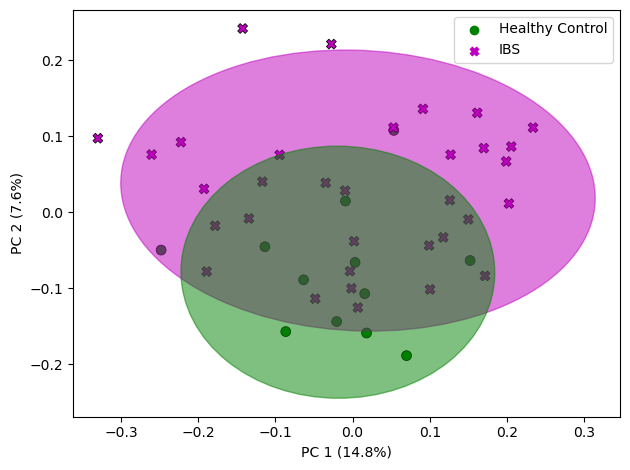

In [24]:
ax = sns.scatterplot(x=0, y=1, 
                    hue="IBS", 
                    palette=["g","m"],
                    style="IBS",
                    data=u_uni_plotdata,
                    edgecolor="black",
                    s=50)

ax.set_xlabel(f"PC 1 ({round(u_uni_pcoa.proportion_explained[0]*100,1)}%)")
ax.set_ylabel(f"PC 2 ({round(u_uni_pcoa.proportion_explained[1]*100,1)}%)")
ax.legend(title=None)

confidence_ellipse(u_uni_plotdata.loc[u_uni_plotdata["IBS"]=="IBS", 0], 
                   u_uni_plotdata.loc[u_uni_plotdata["IBS"]=="IBS", 1], 
                   n_std=2.0,
                   ax=ax, edgecolor='m',
                   alpha=0.5, facecolor='m')
confidence_ellipse(u_uni_plotdata.loc[u_uni_plotdata["IBS"]=="Healthy Control", 0], 
                   u_uni_plotdata.loc[u_uni_plotdata["IBS"]=="Healthy Control", 1], 
                   n_std=2.0,
                   ax=ax, edgecolor='g',
                   alpha=0.5, facecolor='g')


plt.tight_layout()
plt.savefig("Figures/u_uni_IBS_pcoa.pdf")
plt.show()


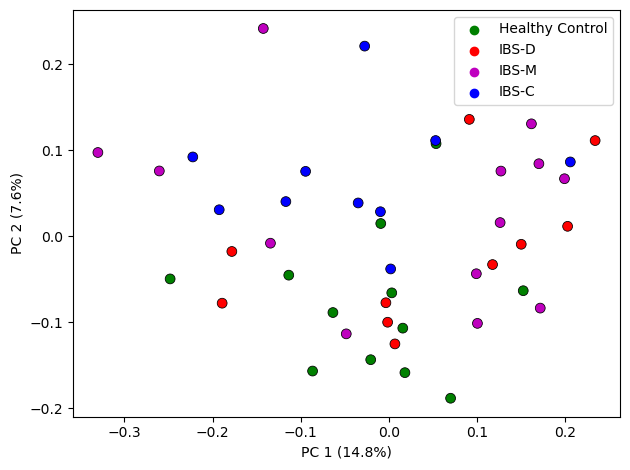

In [6]:
ax = sns.scatterplot(x=0, y=1, 
                    hue="IBS Type", 
                    hue_order=["Healthy Control","IBS-D","IBS-M","IBS-C"],
                    palette=["g","r","m","b"],
                    data=u_uni_plotdata,
                    edgecolor="black",
                    s=50)
ax.set_xlabel(f"PC 1 ({round(u_uni_pcoa.proportion_explained[0]*100,1)}%)")
ax.set_ylabel(f"PC 2 ({round(u_uni_pcoa.proportion_explained[1]*100,1)}%)")
ax.legend(title=None)

plt.tight_layout()

plt.savefig("Figures/u_uni_subtypes_pcoa.pdf")
plt.show()


## Permanova

In [7]:
u_uni_dist = Artifact.load("Data/core-metrics-results/unweighted_unifrac_distance_matrix.qza").view(DistanceMatrix)
metadata_forpermanova = metadata
metadata_forpermanova = metadata_forpermanova.reindex(u_uni_dist.ids)

In [16]:
permanova(u_uni_dist,metadata_forpermanova["IBS"])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      45
number of groups                  2
test statistic             1.633138
p-value                       0.021
number of permutations          999
Name: PERMANOVA results, dtype: object

In [17]:
permanova(u_uni_dist,metadata_forpermanova["IBS Type"])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      45
number of groups                  4
test statistic             1.323841
p-value                        0.02
number of permutations          999
Name: PERMANOVA results, dtype: object